In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../scripts/asset_processor/')
import utils
from video_asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [3]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(sorted(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE)))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [49]:
# read data
data = utils.load_data('../../../data/data-large.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
#data = VideoAssetProcessor.rescale_to_resolution(data, FEATURES_UL+FEATURES_SL+FEATURES_QOE)
len_before = len(data)

In [51]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 11783 NA rows


In [52]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_data = data[~data.index.isin(train_data.index)]
y_test = test_data['target']
y_train = train_data['target']
# assert not np.any(np.isin(train_data.master_id, test_data.master_id))

In [53]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
144p_watermark              529
144p_vignette               529
240p                        529
480p_watermark              529
240p_vignette               529
480p_vignette               529
144p_rotate_90_clockwise    529
360p_rotate_90_clockwise    529
144p                        529
240p_watermark              529
480p_rotate_90_clockwise    529
480p                        529
480p_black_and_white        529
1080p_black_and_white       529
240p_black_and_white        529
Name: rendition, dtype: int64

In [54]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     2780
1    19569
Name: target, dtype: int64

In [55]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_24-30fps/33S9MmkEJzc.mp4                                      0
1080p_24-30fps/AQKale-lyaA.mp4                                      0
1080p_24-30fps/DlknpJcn1QM.mp4                                      0
1080p_24-30fps/Hw161KRfA5I.mp4                                      0
1080p_50-30fps/GDPLXneWvgc_60.mp4                                   0
144p_flip_vertical_50-30fps/olkMNKt5JZ0_60.mp4                      1
1080p_watermark-856x856_50-60fps/olkMNKt5JZ0_60.mp4                 1
144p_black_and_white_24-60fps_gpu/YRXsFtqOeAI.mp4                   1
1080p_flip_horizontal_24-30fps/5bXqi7ReuVU.mp4                      1
144p_24-60fps_gpu/7n3zr8jIaRY.mp4                                   0
1080p_black_and_white_25-30fps_gpu/vYwhOc3LxpM.mp4                  1
240p_rotate_90_counterclockwise_60-30fps/wDlwhPMrd_k_60.mp4         1
144p_rotate_90_clockwise_25-60fps_gpu/vYwhOc3LxpM.mp4               1
1080p_watermark_25-30fps/r5AKa5aVUvE.mp4                            1
1080p_vignette_24

In [56]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [57]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5867212	total: 12.9ms	remaining: 6.46s
1:	learn: 0.4866476	total: 25.2ms	remaining: 6.26s
2:	learn: 0.4060728	total: 34.6ms	remaining: 5.73s
3:	learn: 0.3401048	total: 44.4ms	remaining: 5.5s
4:	learn: 0.2948542	total: 55.8ms	remaining: 5.52s
5:	learn: 0.2538218	total: 65.6ms	remaining: 5.4s
6:	learn: 0.2241618	total: 75.7ms	remaining: 5.33s
7:	learn: 0.2005093	total: 84.9ms	remaining: 5.22s
8:	learn: 0.1817507	total: 95.2ms	remaining: 5.19s
9:	learn: 0.1661256	total: 106ms	remaining: 5.21s
10:	learn: 0.1554964	total: 116ms	remaining: 5.17s
11:	learn: 0.1453412	total: 126ms	remaining: 5.13s
12:	learn: 0.1364063	total: 136ms	remaining: 5.08s
13:	learn: 0.1304940	total: 145ms	remaining: 5.03s
14:	learn: 0.1233238	total: 156ms	remaining: 5.03s
15:	learn: 0.1188041	total: 165ms	remaining: 4.99s
16:	learn: 0.1152290	total: 176ms	remaining: 5s
17:	learn: 0.1104448	total: 185ms	remaining: 4.96s
18:	learn: 0.1063639	total: 195ms	remaining: 4.93s
19:	learn: 0.1027114	total: 205ms	rem

166:	learn: 0.0555439	total: 1.86s	remaining: 3.7s
167:	learn: 0.0554856	total: 1.87s	remaining: 3.69s
168:	learn: 0.0554265	total: 1.89s	remaining: 3.69s
169:	learn: 0.0553756	total: 1.9s	remaining: 3.69s
170:	learn: 0.0553525	total: 1.91s	remaining: 3.67s
171:	learn: 0.0553072	total: 1.92s	remaining: 3.66s
172:	learn: 0.0552504	total: 1.93s	remaining: 3.65s
173:	learn: 0.0551963	total: 1.94s	remaining: 3.63s
174:	learn: 0.0551490	total: 1.95s	remaining: 3.62s
175:	learn: 0.0550915	total: 1.96s	remaining: 3.61s
176:	learn: 0.0550230	total: 1.97s	remaining: 3.6s
177:	learn: 0.0549890	total: 1.98s	remaining: 3.59s
178:	learn: 0.0549638	total: 1.99s	remaining: 3.58s
179:	learn: 0.0549040	total: 2s	remaining: 3.56s
180:	learn: 0.0548363	total: 2.02s	remaining: 3.55s
181:	learn: 0.0547699	total: 2.02s	remaining: 3.54s
182:	learn: 0.0547138	total: 2.04s	remaining: 3.53s
183:	learn: 0.0546360	total: 2.05s	remaining: 3.52s
184:	learn: 0.0545886	total: 2.06s	remaining: 3.51s
185:	learn: 0.0545

328:	learn: 0.0496772	total: 4.31s	remaining: 2.24s
329:	learn: 0.0496518	total: 4.32s	remaining: 2.23s
330:	learn: 0.0496330	total: 4.34s	remaining: 2.21s
331:	learn: 0.0496226	total: 4.35s	remaining: 2.2s
332:	learn: 0.0495963	total: 4.36s	remaining: 2.19s
333:	learn: 0.0495796	total: 4.37s	remaining: 2.17s
334:	learn: 0.0495666	total: 4.39s	remaining: 2.16s
335:	learn: 0.0495501	total: 4.41s	remaining: 2.15s
336:	learn: 0.0495288	total: 4.43s	remaining: 2.14s
337:	learn: 0.0495046	total: 4.45s	remaining: 2.13s
338:	learn: 0.0494743	total: 4.47s	remaining: 2.12s
339:	learn: 0.0494597	total: 4.48s	remaining: 2.11s
340:	learn: 0.0494315	total: 4.51s	remaining: 2.1s
341:	learn: 0.0494092	total: 4.53s	remaining: 2.09s
342:	learn: 0.0493819	total: 4.55s	remaining: 2.08s
343:	learn: 0.0493590	total: 4.57s	remaining: 2.07s
344:	learn: 0.0493359	total: 4.59s	remaining: 2.06s
345:	learn: 0.0493207	total: 4.61s	remaining: 2.05s
346:	learn: 0.0492965	total: 4.64s	remaining: 2.04s
347:	learn: 0.

489:	learn: 0.0468504	total: 6.57s	remaining: 134ms
490:	learn: 0.0468387	total: 6.58s	remaining: 121ms
491:	learn: 0.0468286	total: 6.59s	remaining: 107ms
492:	learn: 0.0468200	total: 6.6s	remaining: 93.8ms
493:	learn: 0.0468092	total: 6.62s	remaining: 80.4ms
494:	learn: 0.0467990	total: 6.63s	remaining: 66.9ms
495:	learn: 0.0467754	total: 6.64s	remaining: 53.5ms
496:	learn: 0.0467647	total: 6.65s	remaining: 40.1ms
497:	learn: 0.0467429	total: 6.66s	remaining: 26.8ms
498:	learn: 0.0467301	total: 6.67s	remaining: 13.4ms
499:	learn: 0.0467130	total: 6.69s	remaining: 0us


In [58]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

Training QoE model:
0:	learn: 0.1497845	total: 10.9ms	remaining: 1.07s
1:	learn: 0.1444590	total: 21.5ms	remaining: 1.05s
2:	learn: 0.1395887	total: 34.1ms	remaining: 1.1s
3:	learn: 0.1351877	total: 44.7ms	remaining: 1.07s
4:	learn: 0.1306689	total: 56.4ms	remaining: 1.07s
5:	learn: 0.1265722	total: 67.2ms	remaining: 1.05s
6:	learn: 0.1229624	total: 78.1ms	remaining: 1.04s
7:	learn: 0.1194715	total: 89.3ms	remaining: 1.03s
8:	learn: 0.1160120	total: 100ms	remaining: 1.01s
9:	learn: 0.1129766	total: 111ms	remaining: 997ms
10:	learn: 0.1099247	total: 123ms	remaining: 991ms
11:	learn: 0.1070815	total: 134ms	remaining: 981ms
12:	learn: 0.1043803	total: 146ms	remaining: 977ms
13:	learn: 0.1018197	total: 158ms	remaining: 970ms
14:	learn: 0.0994846	total: 170ms	remaining: 962ms
15:	learn: 0.0972300	total: 185ms	remaining: 969ms
16:	learn: 0.0951632	total: 195ms	remaining: 953ms
17:	learn: 0.0932736	total: 206ms	remaining: 939ms
18:	learn: 0.0914305	total: 218ms	remaining: 928ms
19:	learn: 0.0

In [59]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.5509776	total: 9.96ms	remaining: 4.97s
1:	learn: 0.4154349	total: 20ms	remaining: 4.97s
2:	learn: 0.3223479	total: 30.8ms	remaining: 5.1s
3:	learn: 0.2667388	total: 41ms	remaining: 5.09s
4:	learn: 0.2232955	total: 50.5ms	remaining: 5s
5:	learn: 0.1917855	total: 60.6ms	remaining: 4.99s
6:	learn: 0.1598912	total: 70.6ms	remaining: 4.97s
7:	learn: 0.1352522	total: 80.1ms	remaining: 4.93s
8:	learn: 0.1183517	total: 90.7ms	remaining: 4.95s
9:	learn: 0.1050328	total: 100ms	remaining: 4.92s
10:	learn: 0.0949270	total: 111ms	remaining: 4.92s
11:	learn: 0.0869341	total: 122ms	remaining: 4.96s
12:	learn: 0.0806881	total: 131ms	remaining: 4.92s
13:	learn: 0.0754650	total: 142ms	remaining: 4.92s
14:	learn: 0.0716007	total: 151ms	remaining: 4.89s
15:	learn: 0.0685320	total: 162ms	remaining: 4.89s
16:	learn: 0.0651682	total: 172ms	remaining: 4.88s
17:	learn: 0.0627650	total: 182ms	remaining: 4.89s
18:	learn: 0.0606933	total: 193ms	remaining: 4.89s
19:	learn: 0.0590588	total: 203ms	remain

175:	learn: 0.0456794	total: 2.1s	remaining: 3.86s
176:	learn: 0.0456790	total: 2.11s	remaining: 3.85s
177:	learn: 0.0456742	total: 2.13s	remaining: 3.85s
178:	learn: 0.0456741	total: 2.14s	remaining: 3.83s
179:	learn: 0.0456724	total: 2.15s	remaining: 3.82s
180:	learn: 0.0456715	total: 2.16s	remaining: 3.81s
181:	learn: 0.0456706	total: 2.17s	remaining: 3.8s
182:	learn: 0.0456649	total: 2.19s	remaining: 3.79s
183:	learn: 0.0456649	total: 2.2s	remaining: 3.77s
184:	learn: 0.0456645	total: 2.21s	remaining: 3.77s
185:	learn: 0.0456576	total: 2.23s	remaining: 3.77s
186:	learn: 0.0456576	total: 2.24s	remaining: 3.75s
187:	learn: 0.0456509	total: 2.25s	remaining: 3.74s
188:	learn: 0.0456435	total: 2.27s	remaining: 3.73s
189:	learn: 0.0456382	total: 2.28s	remaining: 3.72s
190:	learn: 0.0456364	total: 2.29s	remaining: 3.71s
191:	learn: 0.0456354	total: 2.3s	remaining: 3.69s
192:	learn: 0.0456280	total: 2.31s	remaining: 3.68s
193:	learn: 0.0456268	total: 2.33s	remaining: 3.67s
194:	learn: 0.04

350:	learn: 0.0452763	total: 4.34s	remaining: 1.84s
351:	learn: 0.0452762	total: 4.36s	remaining: 1.83s
352:	learn: 0.0452762	total: 4.37s	remaining: 1.82s
353:	learn: 0.0452761	total: 4.38s	remaining: 1.81s
354:	learn: 0.0452761	total: 4.39s	remaining: 1.79s
355:	learn: 0.0452760	total: 4.4s	remaining: 1.78s
356:	learn: 0.0452760	total: 4.42s	remaining: 1.77s
357:	learn: 0.0452759	total: 4.43s	remaining: 1.75s
358:	learn: 0.0452759	total: 4.44s	remaining: 1.74s
359:	learn: 0.0452759	total: 4.45s	remaining: 1.73s
360:	learn: 0.0452758	total: 4.46s	remaining: 1.72s
361:	learn: 0.0452758	total: 4.47s	remaining: 1.7s
362:	learn: 0.0452757	total: 4.48s	remaining: 1.69s
363:	learn: 0.0452757	total: 4.49s	remaining: 1.68s
364:	learn: 0.0452757	total: 4.5s	remaining: 1.66s
365:	learn: 0.0452757	total: 4.51s	remaining: 1.65s
366:	learn: 0.0452757	total: 4.52s	remaining: 1.64s
367:	learn: 0.0452757	total: 4.53s	remaining: 1.62s
368:	learn: 0.0452757	total: 4.54s	remaining: 1.61s
369:	learn: 0.0

In [60]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
# estimate optimal threshold to minimize FP rate
full_y_train_pred = catboost_full.predict_proba(full_x_train)[:,1]
fpr, tpr, trhs = roc_curve(train_data['target'], full_y_train_pred, pos_label=1)
full_catboost_thresh = trhs[tpr[fpr<0.01].shape[0]-1]

full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred_label'] = catboost_full.predict(full_x_test)
catboost_full.save_model('../output/models/CB_Full_v2.cbm',
                          format="cbm",
                          export_parameters=None,
                          pool=None)

0:	learn: 0.5807264	total: 10.9ms	remaining: 5.46s
1:	learn: 0.4829380	total: 20ms	remaining: 4.99s
2:	learn: 0.4163384	total: 30.7ms	remaining: 5.08s
3:	learn: 0.3581585	total: 40.1ms	remaining: 4.97s
4:	learn: 0.3073715	total: 50.6ms	remaining: 5.01s
5:	learn: 0.2656202	total: 60.8ms	remaining: 5s
6:	learn: 0.2355363	total: 70.5ms	remaining: 4.96s
7:	learn: 0.2073254	total: 80.9ms	remaining: 4.97s
8:	learn: 0.1906641	total: 92.2ms	remaining: 5.03s
9:	learn: 0.1733332	total: 103ms	remaining: 5.04s
10:	learn: 0.1599062	total: 113ms	remaining: 5.03s
11:	learn: 0.1487249	total: 123ms	remaining: 5.02s
12:	learn: 0.1385688	total: 133ms	remaining: 5s
13:	learn: 0.1293963	total: 143ms	remaining: 4.98s
14:	learn: 0.1227000	total: 153ms	remaining: 4.93s
15:	learn: 0.1176333	total: 163ms	remaining: 4.94s
16:	learn: 0.1123567	total: 175ms	remaining: 4.96s
17:	learn: 0.1074379	total: 184ms	remaining: 4.93s
18:	learn: 0.1031141	total: 195ms	remaining: 4.94s
19:	learn: 0.1004074	total: 206ms	remain

164:	learn: 0.0534710	total: 2.29s	remaining: 4.66s
165:	learn: 0.0534139	total: 2.32s	remaining: 4.66s
166:	learn: 0.0533203	total: 2.33s	remaining: 4.66s
167:	learn: 0.0532553	total: 2.35s	remaining: 4.65s
168:	learn: 0.0532013	total: 2.37s	remaining: 4.64s
169:	learn: 0.0531195	total: 2.39s	remaining: 4.64s
170:	learn: 0.0530849	total: 2.41s	remaining: 4.63s
171:	learn: 0.0530323	total: 2.42s	remaining: 4.62s
172:	learn: 0.0529843	total: 2.44s	remaining: 4.62s
173:	learn: 0.0528810	total: 2.46s	remaining: 4.62s
174:	learn: 0.0528172	total: 2.48s	remaining: 4.61s
175:	learn: 0.0527822	total: 2.5s	remaining: 4.61s
176:	learn: 0.0527303	total: 2.52s	remaining: 4.6s
177:	learn: 0.0526795	total: 2.54s	remaining: 4.59s
178:	learn: 0.0526027	total: 2.56s	remaining: 4.58s
179:	learn: 0.0525536	total: 2.56s	remaining: 4.56s
180:	learn: 0.0525075	total: 2.58s	remaining: 4.54s
181:	learn: 0.0524531	total: 2.59s	remaining: 4.52s
182:	learn: 0.0523957	total: 2.6s	remaining: 4.5s
183:	learn: 0.05

335:	learn: 0.0466204	total: 4.98s	remaining: 2.43s
336:	learn: 0.0466021	total: 5s	remaining: 2.42s
337:	learn: 0.0465680	total: 5.02s	remaining: 2.41s
338:	learn: 0.0465347	total: 5.04s	remaining: 2.39s
339:	learn: 0.0465153	total: 5.05s	remaining: 2.38s
340:	learn: 0.0464831	total: 5.07s	remaining: 2.36s
341:	learn: 0.0464583	total: 5.08s	remaining: 2.35s
342:	learn: 0.0464386	total: 5.09s	remaining: 2.33s
343:	learn: 0.0463990	total: 5.1s	remaining: 2.31s
344:	learn: 0.0463432	total: 5.11s	remaining: 2.3s
345:	learn: 0.0463280	total: 5.13s	remaining: 2.28s
346:	learn: 0.0463071	total: 5.14s	remaining: 2.27s
347:	learn: 0.0462960	total: 5.15s	remaining: 2.25s
348:	learn: 0.0462645	total: 5.17s	remaining: 2.23s
349:	learn: 0.0462188	total: 5.18s	remaining: 2.22s
350:	learn: 0.0461996	total: 5.2s	remaining: 2.21s
351:	learn: 0.0461648	total: 5.21s	remaining: 2.19s
352:	learn: 0.0461333	total: 5.23s	remaining: 2.18s
353:	learn: 0.0461114	total: 5.24s	remaining: 2.16s
354:	learn: 0.0460

In [61]:
# voting model
test_data['meta_voting_pred_label'] = np.logical_and(test_data['cat_cl_y_pred_label'],test_data['ocsvm_pred_label'])
test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2+test_data['ocsvm_pred'])/2

In [62]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


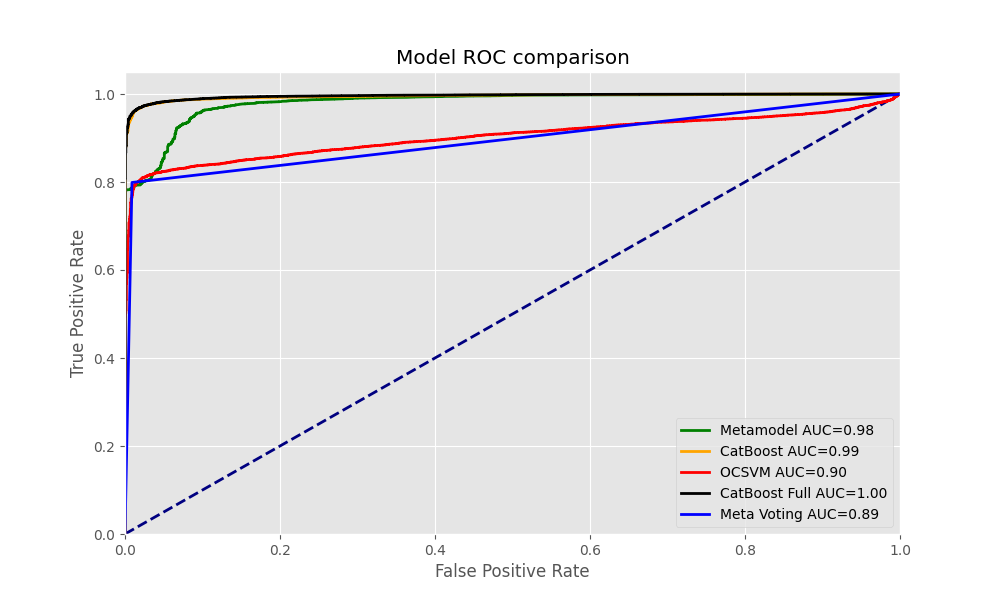

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.96      0.30      0.46      2780
           1       0.91      1.00      0.95     19569

    accuracy                           0.91     22349
   macro avg       0.94      0.65      0.71     22349
weighted avg       0.92      0.91      0.89     22349

Metamodel confusion matrix:
[[  841  1939]
 [   33 19536]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2780
           1       0.99      0.99      0.99     19569

    accuracy                           0.98     22349
   macro avg       0.94      0.96      0.95     22349
weighted avg       0.98      0.98      0.98     22349

CatBoost confusion matrix:
[[ 2593   187]
 [  293 19276]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification repo

In [63]:
multi_model_perf(y_test, [test_data['meta_y_pred'], test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred'], test_data['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

In [64]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.5
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
360p_black_and_white       8
480p_black_and_white       8
144p_black_and_white       8
720p_black_and_white       8
1080p_black_and_white      8
240p_black_and_white       8
720p_watermark-345x114    17
360p                      17
480p                      18
480p_watermark-345x114    23
360p_watermark-345x114    32
240p                      36
240p_watermark-345x114    37
144p_watermark-345x114    58
144p                      84
Name: rendition, dtype: int64

In [65]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,31.881156,temporal_threshold_gaussian_difference-mean
1,2,23.525063,temporal_gaussian_difference-mean
2,3,18.883468,temporal_gaussian_mse-mean
3,1,15.397749,temporal_dct-mean
4,0,10.312564,size_dimension_ratio


FPS Renditions


<IPython.core.display.Javascript object>


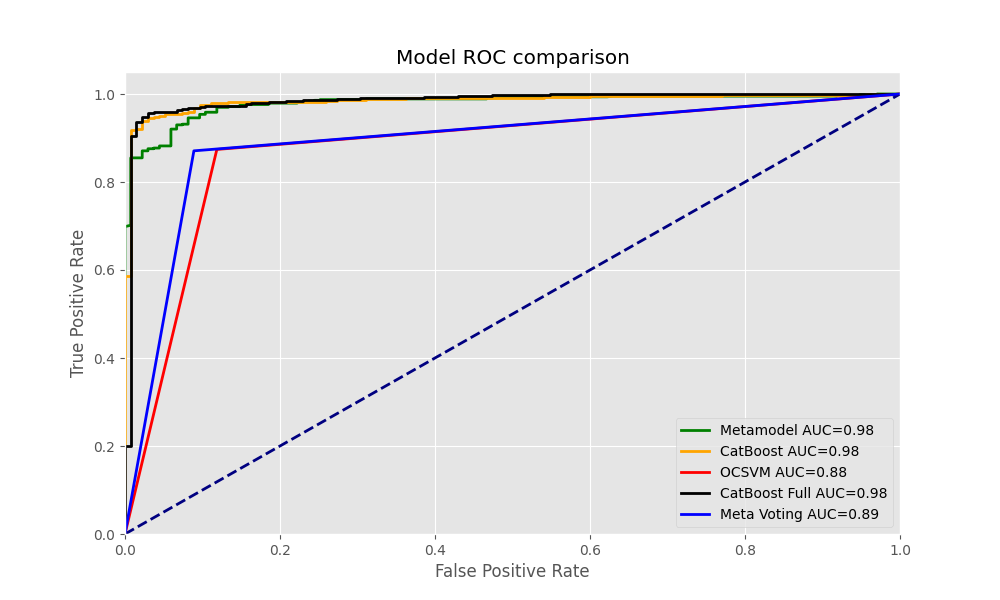

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.90      0.21      0.34       135
           1       0.85      1.00      0.92       627

    accuracy                           0.86       762
   macro avg       0.88      0.60      0.63       762
weighted avg       0.86      0.86      0.82       762

Metamodel confusion matrix:
[[ 28 107]
 [  3 624]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       135
           1       0.94      0.99      0.96       627

    accuracy                           0.93       762
   macro avg       0.93      0.84      0.87       762
weighted avg       0.93      0.93      0.93       762

CatBoost confusion matrix:
[[ 92  43]
 [  7 620]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
            

In [68]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_y_pred'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                       test_data[fps_test_idx]['full_y_pred'], test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

GPU Renditions


<IPython.core.display.Javascript object>


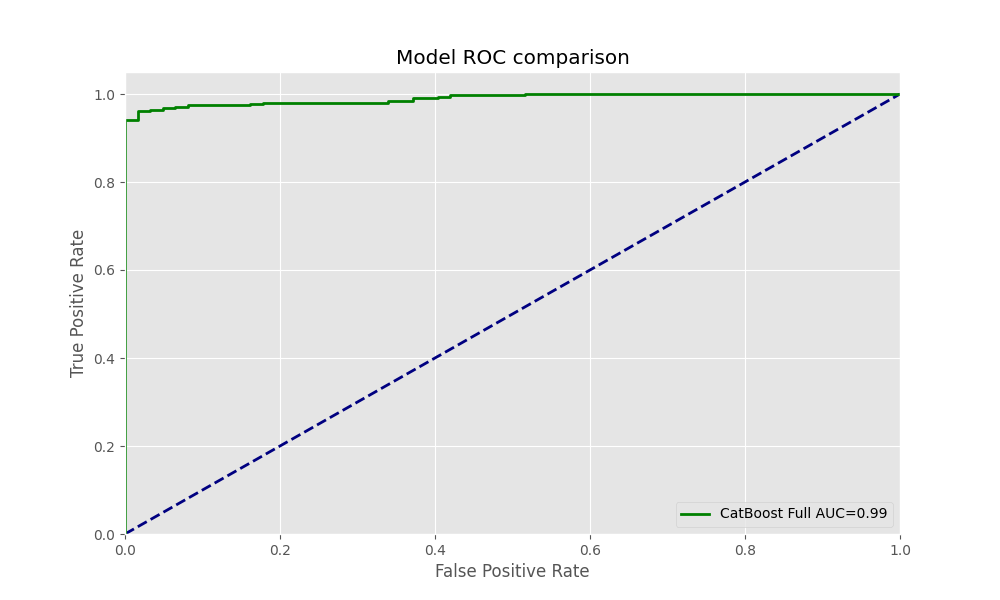

##################
CatBoost Full ROC threshold: 0.5
CatBoost Full classification report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79        62
           1       0.94      0.98      0.96       310

    accuracy                           0.94       372
   macro avg       0.91      0.85      0.87       372
weighted avg       0.93      0.94      0.93       372

CatBoost Full confusion matrix:
[[ 44  18]
 [  6 304]]


In [70]:
print('GPU Renditions')
gpu_test_idx = test_data.id.str.contains('gpu')
y_test_fps = test_data[gpu_test_idx]['target']
gpu_test_data = test_data[gpu_test_idx]
multi_model_perf(y_test_fps, [gpu_test_data['full_y_pred']], 
              ['CatBoost Full'], report_threshold=[0.5])

In [74]:
len(data[data.id.str.contains('fps')])

5397